This is the phase kickback phenemenon

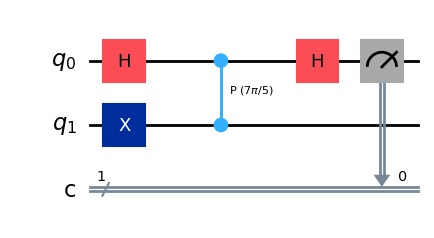

In [21]:
from qiskit import QuantumCircuit, QuantumRegister
from math import pi
import math
from qiskit_aer import AerSimulator
n=2
theta=0.7
qc=QuantumCircuit(n,1)
qc.h(0)
qc.x(1)
qc.cp(2*pi*theta,0,1)
qc.h(0)
qc.measure(0,0)
qc.draw("mpl")



In [28]:
job=AerSimulator().run(qc,shots=100).result()
a=job.get_counts()
cosa=a["0"]/sum(a.values())
sina=a["1"]/sum(a.values())
#print(f"experimented cos(theta)={}")
print(job.get_counts())
print(f"measuring_0: {cosa}")
print(f"measuring_1: {sina}")
print(f"true_measuring_0: {math.cos(pi*theta)**2}")
print(f"true_measuring_1: {math.sin(pi*theta)**2}")

{'0': 35, '1': 65}
measuring_0: 0.35
measuring_1: 0.65
true_measuring_0: 0.34549150281252616
true_measuring_1: 0.6545084971874737


Now doubling the phase. As a result if 2*$\theta$>1, then only the term below decimal will be accounting as it gets multiplied by 2*$\pi$. For example, 2*0.7=1.4 then only 0.4 contributes here so calculating 0.7 and 0.4 will give the same result for phase estimation for a single bit. We first perform phase estimation over 0.7 and then do it for 1.4.


In [32]:

n=2
theta=2*0.7
qc=QuantumCircuit(n,1)
qc.h(0)
qc.x(1)
qc.cp(2*pi*theta,0,1)
qc.h(0)
qc.measure(0,0)
job=AerSimulator().run(qc,shots=100).result()
a=job.get_counts()
cosa=a["0"]/sum(a.values())
sina=a["1"]/sum(a.values())
#print(f"experimented cos(theta)={}")
print(job.get_counts())
print(f"measuring_0: {cosa}")
print(f"measuring_1: {sina}")
print(f"true_measuring_0: {math.cos(pi*theta)**2}")
print(f"true_measuring_1: {math.sin(pi*theta)**2}")



{'1': 96, '0': 4}
measuring_0: 0.04
measuring_1: 0.96
true_measuring_0: 0.09549150281252637
true_measuring_1: 0.9045084971874736


In [31]:
n=2
theta=0.4
qc=QuantumCircuit(n,1)
qc.h(0)
qc.x(1)
qc.cp(2*pi*theta,0,1)
qc.h(0)
qc.measure(0,0)
job=AerSimulator().run(qc,shots=100).result()
a=job.get_counts()
cosa=a["0"]/sum(a.values())
sina=a["1"]/sum(a.values())
#print(f"experimented cos(theta)={}")
print(job.get_counts())
print(f"measuring_0: {cosa}")
print(f"measuring_1: {sina}")
print(f"true_measuring_0: {math.cos(pi*theta)**2}")
print(f"true_measuring_1: {math.sin(pi*theta)**2}")



{'1': 89, '0': 11}
measuring_0: 0.11
measuring_1: 0.89
true_measuring_0: 0.0954915028125263
true_measuring_1: 0.9045084971874736


Now to adress this issue we need more ancilla. Each ancilla will store one binary info.

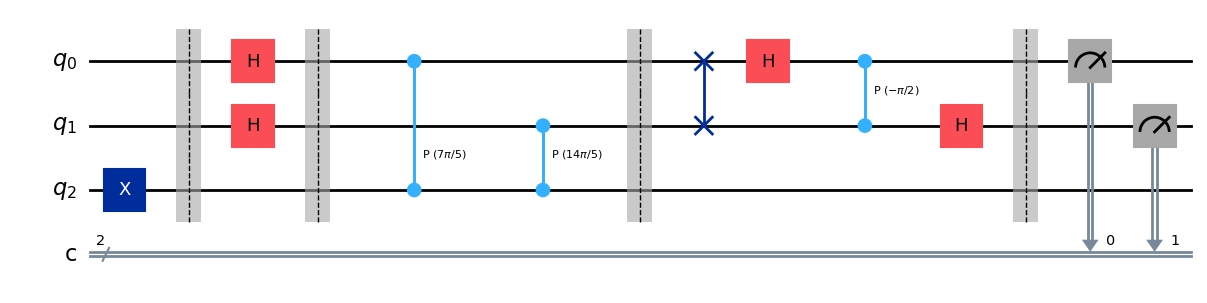

In [33]:
theta = 0.7
qc = QuantumCircuit(3, 2)

# Prepare the eigenvector
qc.x(2)
qc.barrier()

# The initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2 * pi * theta, 0, 2)
qc.cp(2 * pi * (2 * theta), 1, 2)
qc.barrier()

# An implementation of the inverse of the two-qubit QFT
qc.swap(0, 1)
qc.h(0)
qc.cp(-pi / 2, 0, 1)
qc.h(1)
qc.barrier()

# And finally the measurements
qc.measure([0, 1], [0, 1])
display(qc.draw(output="mpl"))

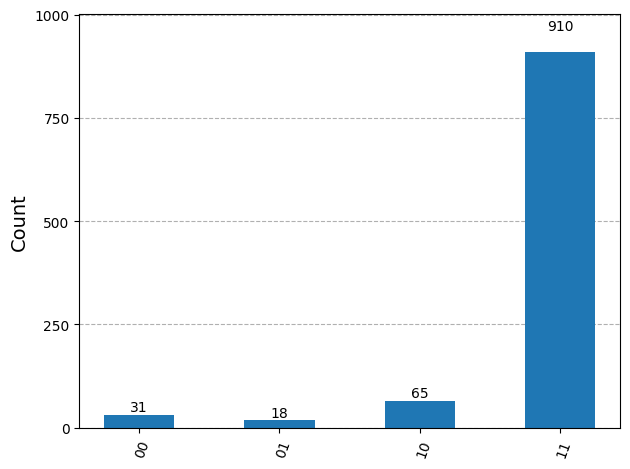

In [35]:
from qiskit.visualization import plot_histogram
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

Recursive QFT: Apply H gate, then apply controlled phase gate in controlled manner for rest of all.

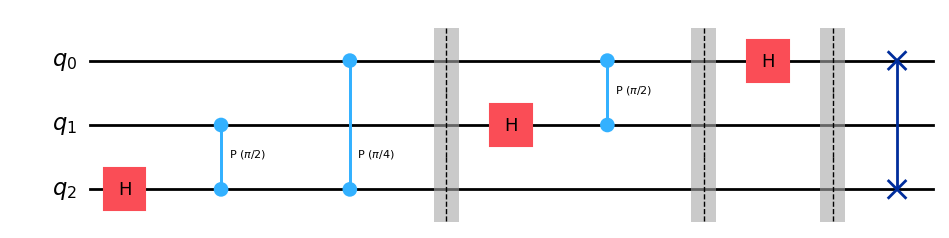

In [68]:
from qiskit import QuantumCircuit
from numpy import pi

# Function to add controlled phase gates
def add_controlled_phases(qc, control_qubit, target_qubits):
    """
    Add the controlled phase gates as per the QFT algorithm.

    Args:
        qc (QuantumCircuit): Quantum circuit object.
        control_qubit (int): Index of the controlling qubit.
        target_qubits (list): Indices of the target qubits.
        total_qubits (int): Total number of qubits.
    """
    for i, target in enumerate(target_qubits):
        angle = 2 * pi / (2 ** (i + 2))  # Phase shift angle
        qc.cp(angle, control_qubit, target)

# Recursive QFT implementation
def qft_recursive(qc, qubits):
    """
    Implement the QFT recursively.

    Args:
        qc (QuantumCircuit): Quantum circuit object.
        qubits (list): List of qubit indices to apply QFT.
    """
    if len(qubits) == 0:
        return

    # Step 1: Apply a Hadamard gate to the top/rightmost qubit
    top_qubit = qubits[0]
    qc.h(top_qubit)

    # Step 2: Use top qubit as a control for phase gates with remaining qubits
    add_controlled_phases(qc, top_qubit, qubits[1:])
    qc.barrier()

    # Step 3: Apply QFT recursively on the remaining qubits
    qft_recursive(qc, qubits[1:])

# Permute the qubits to reverse their order
def reverse_qubits(qc, total_qubits):
    """
    Reverse the order of qubits in the circuit.

    Args:
        qc (QuantumCircuit): Quantum circuit object.
        total_qubits (int): Total number of qubits.
    """
    for i in range(total_qubits // 2):
        qc.swap(i, total_qubits - i - 1)

# Function to implement QFT for 'm' qubits
def qft_circuit(m):
    """
    Build a QFT circuit for m qubits.

    Args:
        m (int): Number of qubits in the QFT.

    Returns:
        QuantumCircuit: The QFT quantum circuit.
    """
    qc = QuantumCircuit(m)

    # Apply the recursive QFT
    qft_recursive(qc, list(range(m)))

    # Reverse the order of the qubits
    reverse_qubits(qc, m)

    return qc.reverse_bits()

# Example: QFT for 4 qubits
m = 3
qft_4 = qft_circuit(m)
qft_4.draw("mpl")


MAIN QPE

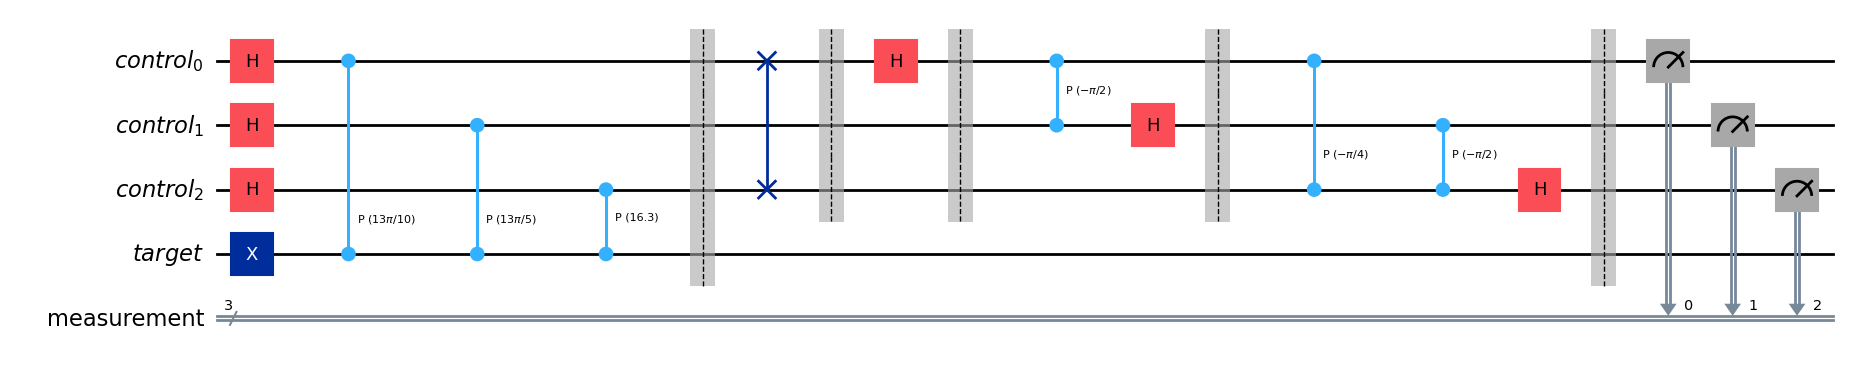

In [135]:
from qiskit.circuit import QuantumRegister,ClassicalRegister
THETA=0.65
m=3
Control=QuantumRegister(m,"control")
target=QuantumRegister(1,"target")
measurement=ClassicalRegister(m,"measurement")
qc1=QuantumCircuit(Control,target,measurement)
qc1.x(target[0])
for i in range(m):
    qc1.h(i)
    qc1.cp(2*pi*THETA*(2**i),Control[i],target[0])
qc1.barrier()
qc1=qc1.compose(qft_circuit(m).inverse())
qc1.barrier()
qc1.measure(Control,measurement)
qc1.draw("mpl")

101
highest: 0.625
{'101': 891, '100': 19, '110': 60, '001': 5, '111': 10, '000': 5, '011': 9, '010': 1}


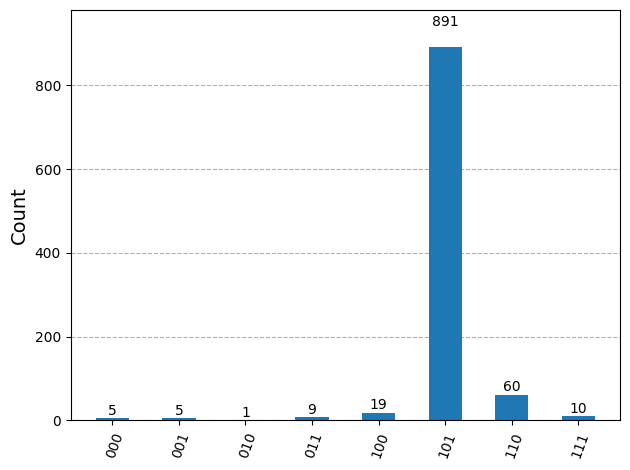

In [138]:
job=AerSimulator().run(qc1,shots=1000).result()
b=job.get_counts()
z=max(b,key=b.get)
print(z)
def bintofracdec(a):
    a=list(a)
    b=len(a)
    c=0
    for i in range(b):
        c=int(a[i])/2**(i+1)+c
    return c
print(f"highest: {bintofracdec(z)}")
print(b)
plot_histogram(job.get_counts())
